In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "10:30:00"
NUM_CLUSTER = 50
TIME_STEP = 5
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
    X = []
    Y = []
    h1, m1, s1 = [int(x) for x in BEGIN_TIME.split(":")]
    h2, m2, s2 = [int(x) for x in END_TIME.split(":")]
    t1 = dt.timedelta(hours = h1, minutes=m1)
    t2 = dt.timedelta(hours = h2, minutes=m2)
    total_mins = (t2-t1).total_seconds()//60
    
    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "return"]
                if len(front_df) == (90 // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

def dtw_d(X, Y):
    manhattan_distance = lambda x, y: np.abs(x - y)
    d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
    return d

def dtw_affinity(X):
    return pairwise_distances(X, metric=dtw_d)

def fastdtw_d(X, Y):
    return fastdtw(X, Y, dist=euclidean)[0]

def fastdtw_affinity(X):
    return pairwise_distances(X, metric=fastdtw_d)


X, Y = load_data()


100%|██████████| 13/13 [00:14<00:00,  1.13s/it]


In [3]:
X_test, Y_test = load_data(train=False)


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


In [4]:
print(X.shape)

(2990, 19)


In [5]:
print(X_test.shape)

(915, 19)


t1 = time.time()
fastdtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)
t1 = time.time()
dtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)

In [6]:
t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = fastdtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

14372.75212264061


t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = dtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [7]:
X_label

array([32,  2, 11, ..., 47, 41,  9], dtype=int64)

In [9]:
pickle.dump(X_table, open(os.path.join('dataset_pk',"X.pk"), "wb"))
pickle.dump(X_table, open(os.path.join('dataset_pk',"Y.pk"), "wb"))
# pickle.dump(X_table, open(os.path.join('dataset_pk',"X_tabel.pk"), "wb"))

NameError: name 'X_table' is not defined

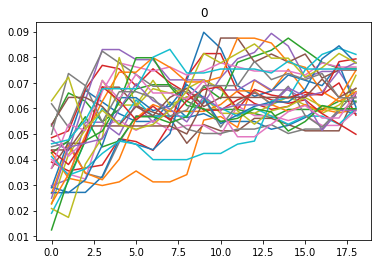

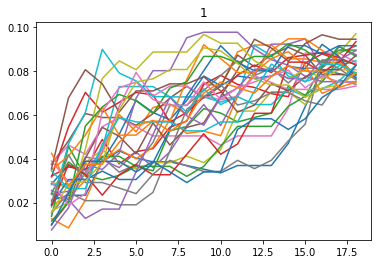

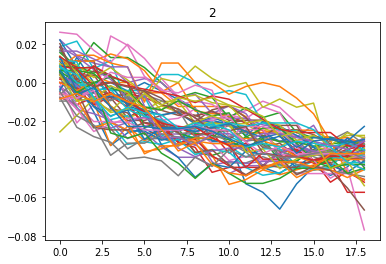

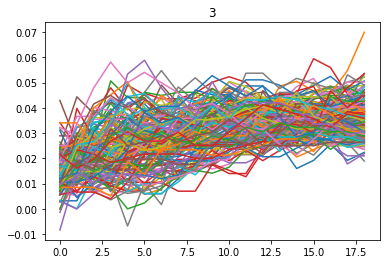

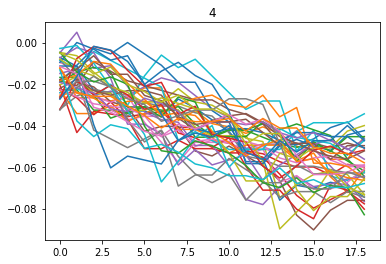

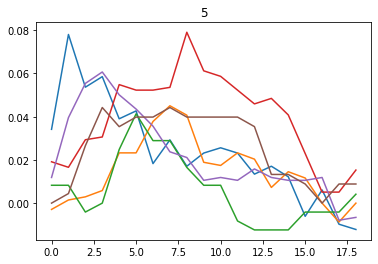

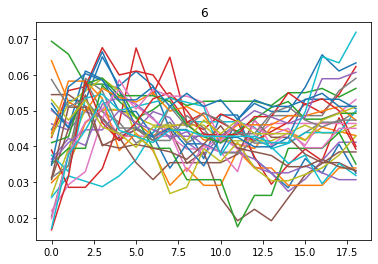

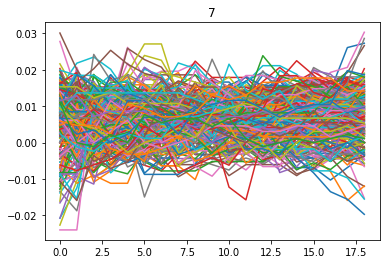

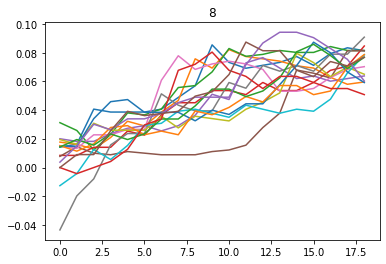

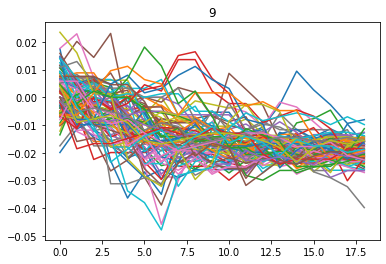

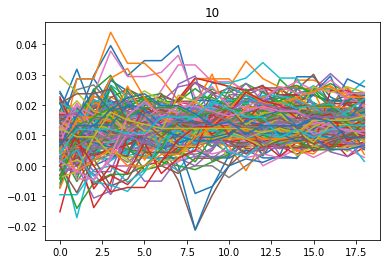

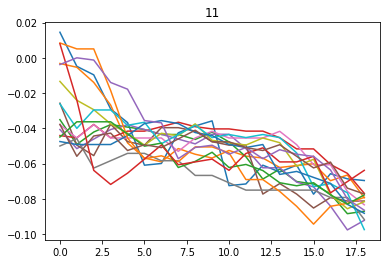

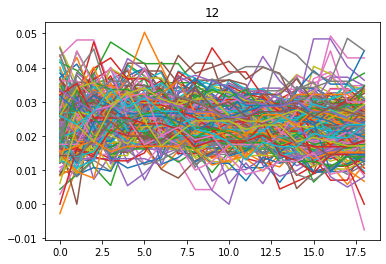

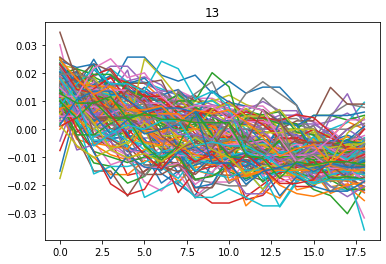

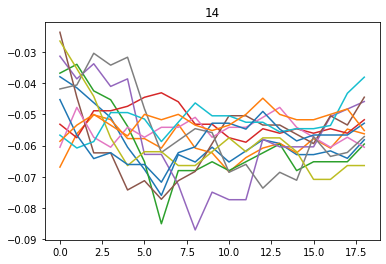

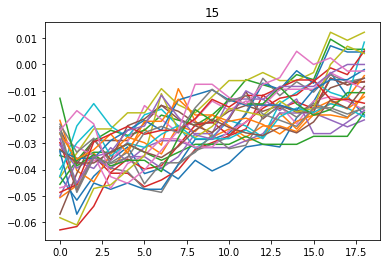

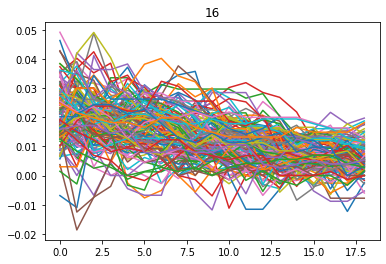

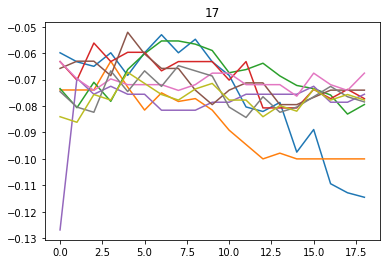

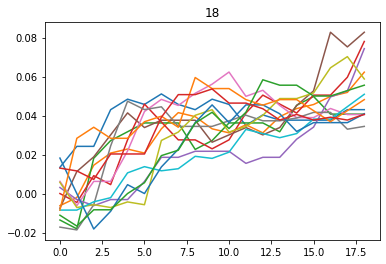

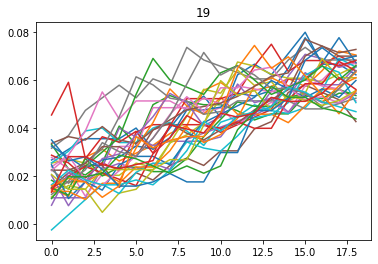

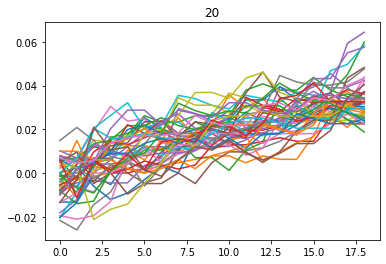

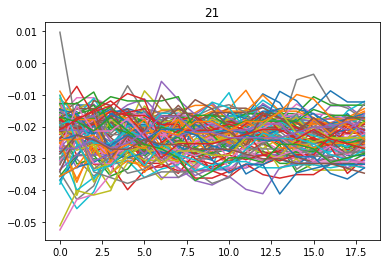

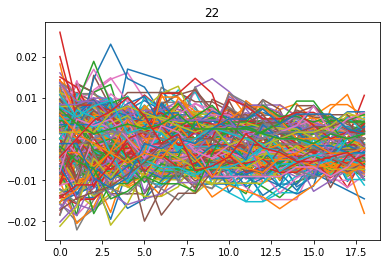

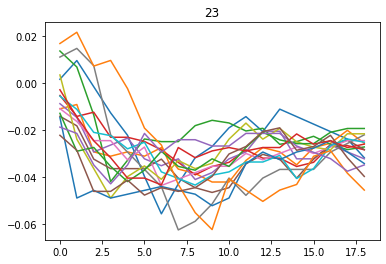

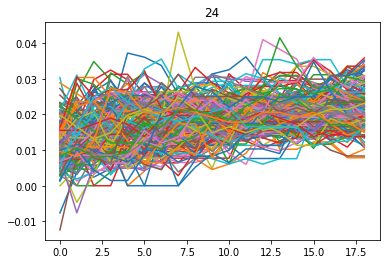

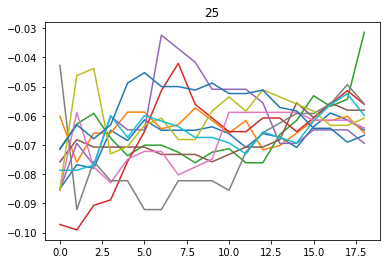

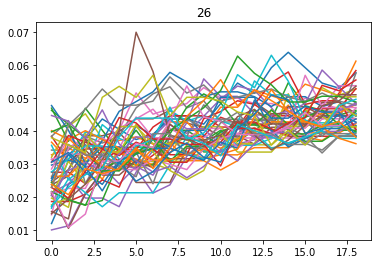

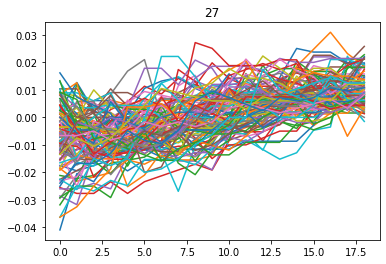

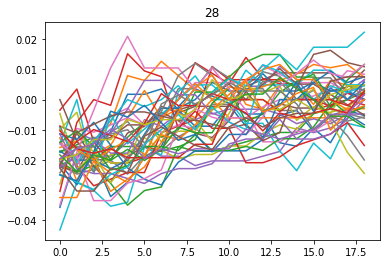

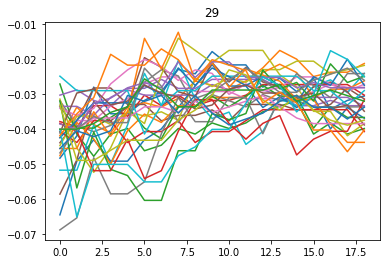

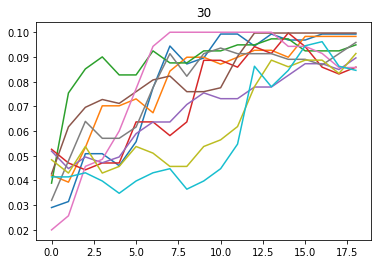

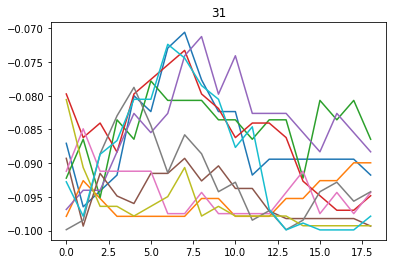

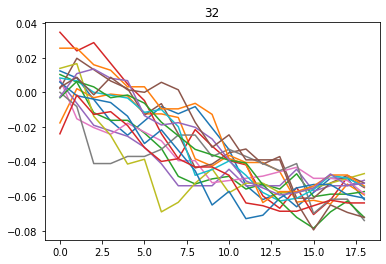

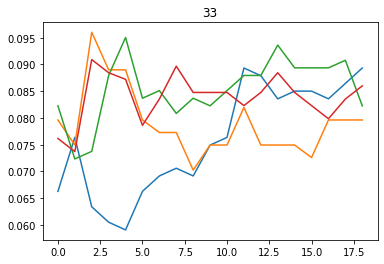

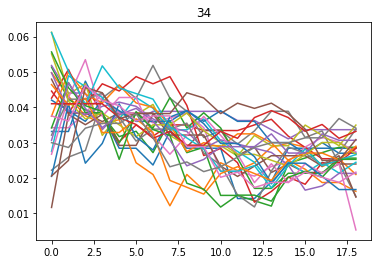

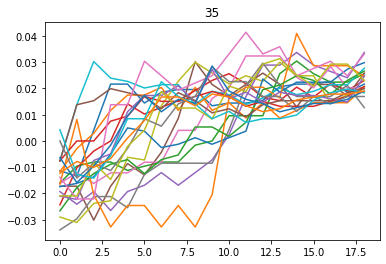

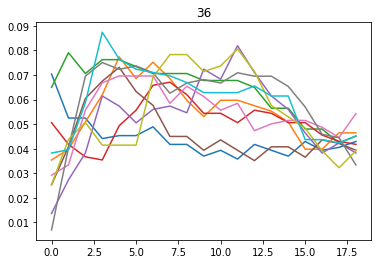

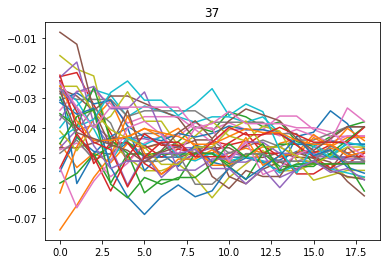

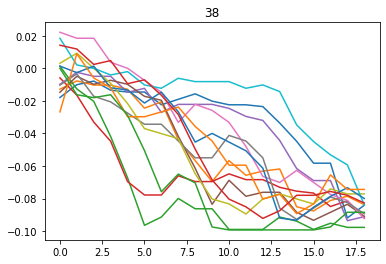

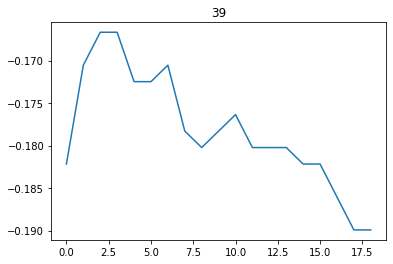

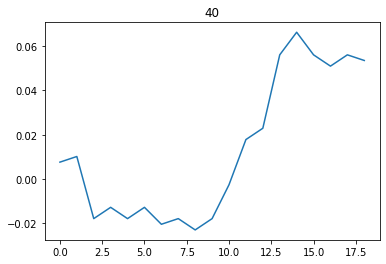

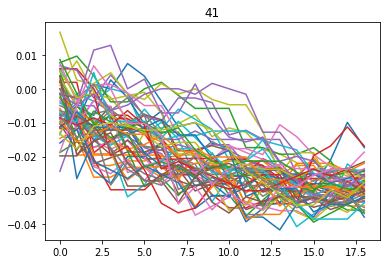

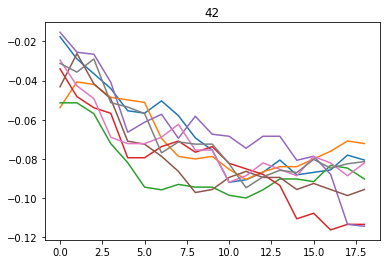

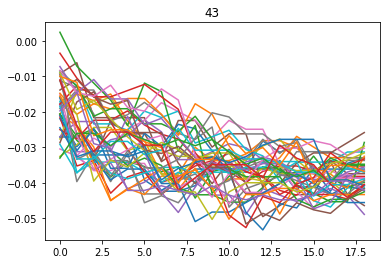

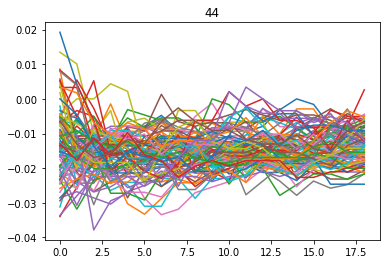

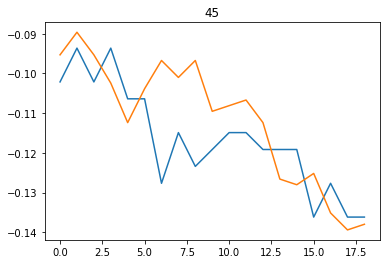

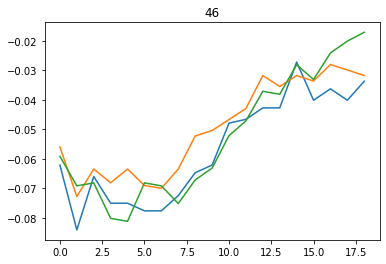

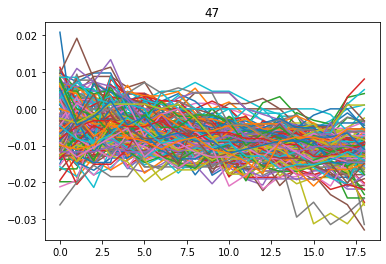

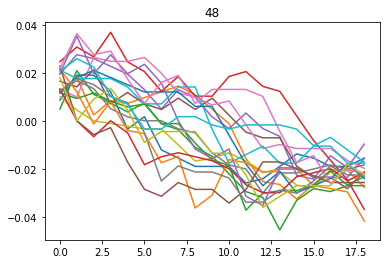

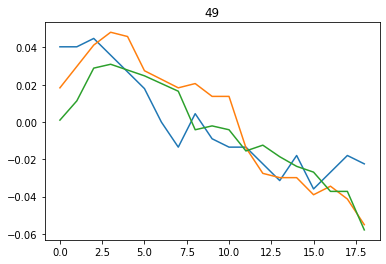

In [10]:
for n in range(NUM_CLUSTER):
    plt.title(n)
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == n:
            plt.plot(X[i])
    plt.show()

In [11]:
def make_long_simple(y, cost):
    return y.max() - y[0] - cost
def make_short_simple(y, cost):
    return y[0] - y.min() - cost
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0] - y.max() - cost
def make_long(y, cost, exp_profit):
    if (y-y[0]-cost >= exp_profit).any():
        return exp_profit
    else:
        return y[-1] - y[0] - cost

def make_short(y, cost, exp_profit):
    if (y[0]-y-cost >= exp_profit).any():
        return exp_profit
    else:
        return -y[-1] + y[0] - cost

In [12]:
def make_table(X, X_label):
    X_mean = np.zeros((len(X_label), len(X[0])))
    for i in range(NUM_CLUSTER):
        X_mean[X_label[i]] = X[X_label==i].mean(axis=0)
    return X_mean
X_table = make_table(X, X_label)
pickle.dump(X_table, open(os.path.join('dataset_pk',"X_tabel.pk"), "wb"))

In [ ]:
len(X)

In [ ]:
Y.shape

In [13]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long_simple(Y[i], 0.002)
    profit_short_array[X_label[i]] += make_short_simple(Y[i], 0.002)
    lost_long_array[X_label[i]] += make_long_max_lost(Y[i], 0.002)
    lost_short_array[X_label[i]] += make_short_max_lost(Y[i], 0.002)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print(profit_long_array)
print(profit_short_array)
print(lost_long_array)
print(lost_short_array)
print(num_long_array)
print(num_short_array)

[ 0.43934425  0.40102071  0.60849231  2.35247634  0.56104034  0.12993264
  0.35344259  3.32518678  0.16825013  0.78589349  1.72751478  0.34142371
  2.04415519  1.27270442  0.1139634   0.58325393  1.17039394  0.15008409
  0.27366811  0.67742166  0.777988    0.84794856  1.49580113  0.32497245
  1.6079381   0.18769989  0.79976887  1.39442379  0.35932683  0.56142162
  0.04986534 -0.00930104  0.29780163  0.0452141   0.34014975  0.29967426
  0.08474175  0.43427847  0.22911021  0.00768992  0.03362341  0.41795598
  0.04056743  0.34513961  0.92534847  0.03858951  0.08107355  1.0137011
  0.38179684  0.07355982]
[ 5.78043383e-01  4.48253380e-01  1.06102647e+00  1.95049925e+00
  7.85479512e-01  9.30496228e-02  5.89666632e-01  3.15838670e+00
  2.67546982e-01  1.10308357e+00  1.60096855e+00  1.94030483e-01
  2.69139476e+00  1.91481929e+00  2.27461857e-01  2.82655164e-01
  2.12338256e+00  1.22818708e-01  3.45029189e-01  4.82966947e-01
  5.49718144e-01  1.19775622e+00  2.34264011e+00  2.56534345e-01
 

In [ ]:
pickle.dump(ac, open("ac_model2.pc", 'wb'))

In [ ]:
ac = pickle.load(open("ac_model2.pc", 'rb'))

In [14]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long_simple(Y[i], 0.002)
    profit_short_array[X_label[i]] += make_short_simple(Y[i], 0.002)
    lost_long_array[X_label[i]] += make_long_max_lost(Y[i], 0.002)
    lost_short_array[X_label[i]] += make_short_max_lost(Y[i], 0.002)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('best avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('best avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print('worst avg long return', sorted(lost_long_array/num_long_array)[::-1][:10])
print('worst avg short return', sorted(lost_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)

best avg long return [0.03362340966921118, 0.0270245152118065, 0.024519939896464463, 0.02165544072034196, 0.021338982087221917, 0.020830497628022616, 0.020310777825809593, 0.01992416659043493, 0.019547722362591002, 0.019294755001361942]
best avg short return [0.035915876583750006, 0.031078880407124677, 0.029578135767439888, 0.029102259523078634, 0.026138752737937778, 0.025255640898715438, 0.024644942057371978, 0.022143379431450064, 0.019311947939858885, 0.019268112773592208]
worst avg long return [-0.002, -0.003422475106685625, -0.0069613450633379355, -0.012417839798957818, -0.01294727110513606, -0.01322299256801334, -0.013362389165665527, -0.013952412470061976, -0.014094827288562971, -0.014146328016101205]
worst avg short return [-0.0030698959164999562, -0.008986534493089034, -0.009070928144753007, -0.009888980827251249, -0.009893611056510687, -0.011083999719796886, -0.01166976911696663, -0.011689922480620172, -0.011811452890817763, -0.01233128550814956]
[ 30  32  62 156  42   6  31 3

In [15]:
def find_cluster(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = dtw_d(X, X_table[i])
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [ ]:
def find_cluster_L2(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = np.sum((X - X_table[i])**2)
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [ ]:
find_cluster_L2(X_test[0], X_table)

In [26]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long(Y[i], 0.002, 0.025)
    profit_short_array[X_label[i]] += make_short(Y[i], 0.002, 0.025)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)
best_long_cluster = np.argsort(profit_long_array/num_long_array)[::-1]
best_short_cluster = np.argsort(profit_short_array/num_short_array)[::-1]

avg long return [0.025, 0.010077524893314375, 0.008699819338138326, 0.0039774438347150425, 0.0032446292673297223, 0.001994902888959029, 0.0015224025474199088, 0.0012173710521863515, 0.0005237636335275713, 0.00011740376430761966]
avg short return [0.025, 0.009620098218332882, 0.00928028564202744, 0.007156632615707422, 0.006867216839515274, 0.006127626623991532, 0.005558677164400767, 0.004589809256946441, 0.004573753187043948, 0.004016013652128005]
[ 30  32  62 156  42   6  31 353  16  90 171  16 200 133  12  28 135   9
  14  34  47  96 254  16 193  11  52 111  46  33  10  10  16   4  28  22
  10  37  14   1   1  59   8  45  96   2   3 172  20   3]
[ 30  32  62 156  42   6  31 353  16  90 171  16 200 133  12  28 135   9
  14  34  47  96 254  16 193  11  52 111  46  33  10  10  16   4  28  22
  10  37  14   1   1  59   8  45  96   2   3 172  20   3]


In [27]:
best_short_cluster

array([40, 42, 36, 14, 41, 43, 16,  2, 34, 32,  4, 28, 31, 47, 37,  5, 22,
       13,  9, 12, 11, 25,  6, 17, 24,  8, 39, 21,  7, 18, 38, 45, 44, 10,
        0,  3, 26,  1, 48, 27, 33, 30, 23, 20, 35, 49, 19, 29, 46, 15],
      dtype=int64)

In [17]:
best_long_cluster

array([40, 45, 15, 19, 35, 29,  5, 20,  1, 11, 46, 30,  3, 27,  0, 26, 39,
       44, 10,  7, 38, 48,  8, 23, 24, 21,  9, 22, 31, 12, 18, 13, 47, 37,
       14, 28,  2,  4,  6, 32, 16, 17, 43, 25, 41, 42, 33, 34, 36, 49],
      dtype=int64)

In [20]:
def evaluate(X_test, Y_test, X_table, exp_profit=0.025):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    lost_long_array = np.zeros(NUM_CLUSTER)
    lost_short_array = np.zeros(NUM_CLUSTER)
    num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
    X_label = np.zeros(NUM_CLUSTER).astype("int")
    for i in tqdm(range(len(X_test))):
        X_label = find_cluster(X_test[i], X_table)
        # profit_long_array[X_label] += make_long(Y_test[i], 0.002, exp_profit)
        profit_short_array[X_label] += make_short(Y_test[i], 0.002, exp_profit)
        num_exchange_array[X_label] += 1
    return profit_long_array, profit_short_array, num_exchange_array 


In [ ]:
profit_long_array, profit_short_array, num_long_array  = evaluate(X_test, Y_test, X_table)


 34%|███▎      | 308/915 [00:20<00:40, 15.09it/s]


 65%|██████▌   | 598/915 [00:39<00:20, 15.17it/s]

In [ ]:
for i in range(len(best_long_cluster)):
    print(i, profit_short_array[best_short_cluster[i]], num_short_array[best_short_cluster[i]])

In [ ]:
best_long_cluster = np.argsort(profit_long_array/num_long_array)[::-1]
for n in range(10):
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == n:
            plt.plot(X[i])
    plt.show()

In [ ]:
print()